In [2]:
import sys
import os
from IPython.display import Image
import pandas as pd
from pathlib import Path


# Replace with the actual path to your pyxations package
package_path = "../pyxations"
sys.path.append(package_path)
import pyxations as pyx
from pyxations import compute_derivatives_for_dataset, dataset_to_bids, Experiment
import os
from pyxations.export import FEATHER_EXPORT, HDF5_EXPORT

# Dataset to BIDS

# Compute derivatives

In [3]:
base_folder = os.path.dirname(os.getcwd())
files_folder_path = os.path.join(base_folder,"tests","data","example_files")

bids_dataset_folder = dataset_to_bids(base_folder,files_folder_path,"example_dataset")

start_msgs = {'search':['beginning_of_stimuli']}
end_msgs= {'search':['end_of_stimuli']}
msg_keywords = ["begin","end","press"]

In [ ]:
# eyelink
derivatives_path = compute_derivatives_for_dataset(bids_dataset_folder,
                                                   dataset_format='eyelink',  
                                                   detection_algorithm='eyelink',
                                                   msg_keywords=msg_keywords, 
                                                   start_msgs=start_msgs, 
                                                   end_msgs=end_msgs)

derivatives_path

In [ ]:
# remodnav
compute_derivatives_for_dataset(
    bids_dataset_folder, 'eyelink', detection_algorithm= 'remodnav', msg_keywords=msg_keywords, 
    start_msgs=start_msgs, end_msgs=end_msgs, overwrite=True,
    max_pso_dur=0, min_fix_dur=0, sac_max_vel=999, savgol_length= 0.195,
)

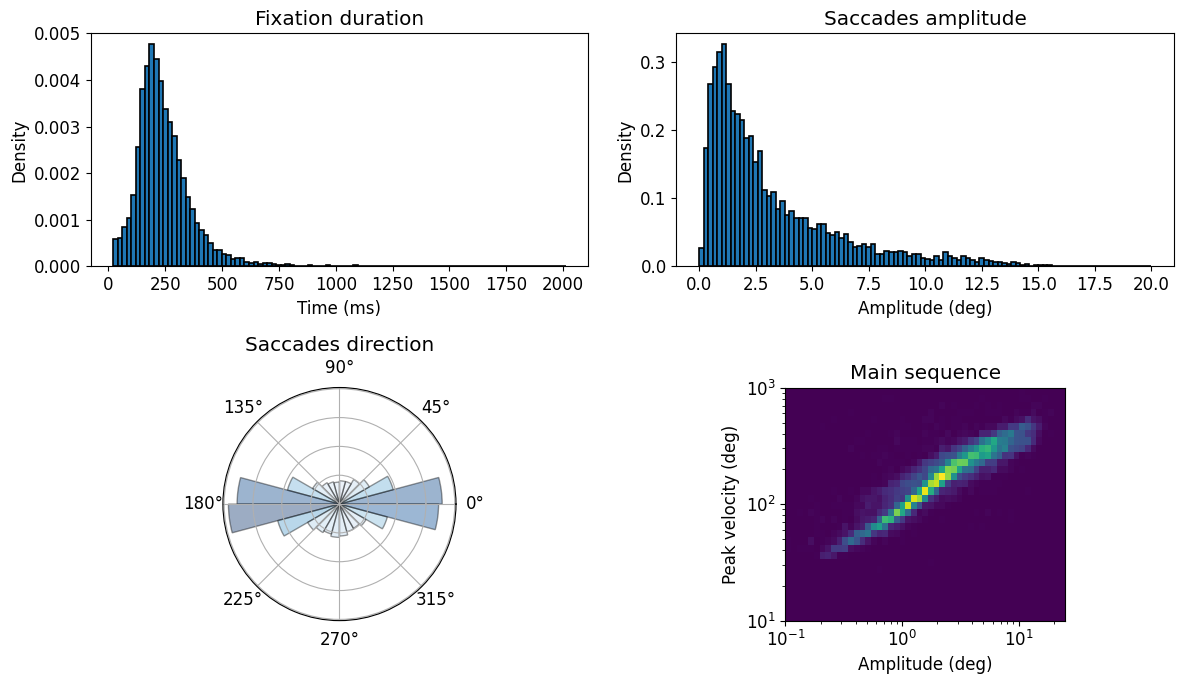

In [53]:
exp = pyx.Experiment(bids_dataset_folder)
exp.load_data("eyelink")

# Some plots
exp.plot_multipanel(True)

In [54]:
# Retrieve data for specific trial
exp.get_trial(subject_id='0001', session_id='second',trial_number=1).saccades()

,index,eye,tStart,tEnd,duration,xStart,yStart,xEnd,yEnd,ampDeg,...,Line_number,Eyes_recorded,Rate_recorded,Calib_index,bad,phase,trial_number,trial_label,deg,dir
0,86,R,340.0,376.0,37,949.0,565.5,1037.0,612.6,1.57,...,50637,LR,1000.0,1,False,search,1,,28.156904,
1,87,R,716.0,747.0,32,1032.1,634.7,823.7,687.7,3.37,...,51018,LR,1000.0,1,False,search,1,,165.731111,left
2,88,R,956.0,1768.0,813,820.6,688.6,467.3,569.6,5.80,...,52060,LR,1000.0,1,False,search,1,,-161.385228,
3,89,R,2049.0,2083.0,35,471.7,572.3,526.4,607.1,1.00,...,52379,LR,1000.0,1,False,search,1,,32.464414,
4,90,R,2309.0,2321.0,13,554.1,617.3,529.1,649.8,0.64,...,52623,LR,1000.0,1,False,search,1,,127.568592,
5,91,R,2684.0,2760.0,77,541.1,628.6,1289.9,658.2,11.65,...,53072,LR,1000.0,1,False,search,1,,2.263719,right
6,92,R,3046.0,3054.0,9,1311.5,644.1,1335.3,652.9,0.40,...,53373,LR,1000.0,1,False,search,1,,20.291768,


## Saccades

In [55]:
remodnav_sacc_path = derivatives_path / "sub-0001" / "ses-second" / "remodnav_events" / "sacc.feather"
eyelink_sacc_path = derivatives_path / "sub-0001" / "ses-second" / "eyelink_events" / "sacc.feather"


In [56]:
df_remodnav = pd.read_feather(remodnav_sacc_path)
df_remodnav

,index,tStart,tEnd,xStart,yStart,xEnd,yEnd,ampDeg,vPeak,med_vel,...,Calib_index,Eyes_recorded,Rate_recorded,eye,bad,phase,trial_number,trial_label,deg,dir
0,0,2357659.0,2357772.0,847.048346,435.055277,911.699516,505.816191,1.754348,18.931974,16.302080,...,1,LR,1000.0,R,False,,-1,,47.583413,
1,1,2360822.0,2360970.0,867.170602,579.467014,559.014849,795.989350,6.893407,65.996927,50.514879,...,1,LR,1000.0,R,False,,-1,,144.906616,
2,2,2361020.0,2361172.0,552.425184,799.096959,310.023213,912.625750,4.899279,42.629253,34.313535,...,1,LR,1000.0,R,False,,-1,,154.903991,
3,3,2364921.0,2365202.0,384.599116,997.517317,828.512733,1016.706165,8.132714,42.960928,26.531914,...,1,LR,1000.0,R,False,,-1,,2.475157,right
4,4,2368975.0,2369319.0,968.814315,778.144294,981.488536,205.653255,10.481097,50.439767,31.618301,...,1,LR,1000.0,R,False,,-1,,-88.731752,up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,12,3816284.0,3816326.0,940.777165,543.192638,942.941668,567.305478,0.423961,19.620400,11.506323,...,5,LR,1000.0,L,False,,-1,,84.870560,down
638,13,3816835.0,3816980.0,947.513472,581.682692,1315.657538,596.689511,6.743882,67.488273,51.225531,...,5,LR,1000.0,L,False,search,92,,2.334281,right
639,14,3817786.0,3817908.0,1388.320785,630.214198,823.221853,478.542146,10.709304,119.378374,97.949732,...,5,LR,1000.0,L,False,search,92,,-164.975951,
640,15,3822436.0,3822553.0,1081.356987,639.557279,938.945164,501.020258,3.636513,43.231785,36.713471,...,5,LR,1000.0,L,False,,-1,,-135.790164,


In [57]:
df_eyelink = pd.read_feather(eyelink_sacc_path)
df_eyelink

,index,eye,tStart,tEnd,duration,xStart,yStart,xEnd,yEnd,ampDeg,...,Line_number,Eyes_recorded,Rate_recorded,Calib_index,bad,phase,trial_number,trial_label,deg,dir
0,0,R,2356956,2357090,135,844.9,432.0,860.7,369.8,1.01,...,375,LR,1000.0,1,False,,-1,,-75.747220,up
1,1,R,2357343,2357530,188,850.4,413.6,851.2,348.2,1.03,...,827,LR,1000.0,1,False,,-1,,-89.299169,up
2,2,R,2357696,2357719,24,844.4,435.3,925.2,498.5,1.61,...,1022,LR,1000.0,1,False,,-1,,38.031743,
3,3,R,2357879,2357889,11,915.7,523.3,943.2,542.2,0.52,...,1202,LR,1000.0,1,False,,-1,,34.499680,
4,4,R,2360721,2360753,33,946.1,564.5,883.8,578.6,1.00,...,4074,LR,1000.0,1,False,,-1,,167.247420,left
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004,69,L,3825826,3825876,51,773.6,602.1,522.3,766.4,4.68,...,847228,LR,1000.0,5,False,search,93,,146.823331,
2005,70,L,3826160,3826180,21,486.4,780.2,504.1,853.1,1.16,...,847540,LR,1000.0,5,False,search,93,,76.352762,down
2006,71,L,3826649,3826670,22,495.3,833.4,428.9,882.1,1.27,...,848038,LR,1000.0,5,False,search,93,,143.742422,
2007,72,L,3827120,3827135,16,459.7,865.8,513.1,871.6,0.83,...,848511,LR,1000.0,5,False,search,93,,6.198837,right


In [58]:
import matplotlib.pyplot as plt

def plot_comparison(df_eyelink, df_remodnav, trial:int=None):
    if trial:
        df_eyelink = df_eyelink[df_eyelink['trial_number']== trial]
        df_remodnav = df_remodnav[df_remodnav['trial_number']== trial]
    
    # Plot settings
    fig, ax = plt.subplots(figsize=(10, 2))

    # Plot segments for df1
    for start, end in zip(df_eyelink["tStart"], df_eyelink["tEnd"]):
        #ax.plot([start, end], [1, 1], color="blue", marker="o", label="Series 1" if start == df_eyelink["tStart"][0] else "")
        ax.plot([start, end], [1, 1], color="blue", marker="o", label="Eyelink" )


        # Plot segments for df2
    for start, end in zip(df_remodnav["tStart"], df_remodnav["tEnd"]):
        #ax.plot([start, end], [2, 2], color="red", marker="o", label="Series 2" if start == df_remodnav["tStart"][0] else "")
        ax.plot([start, end], [2, 2], color="red", marker="x", label="Remodnav")

    # Customize the y-axis to label the series
    ax.set_yticks([1, 2])
    ax.set_yticklabels(["Eyelink", "Remodnav"])

    # Add labels and title
    ax.set_xlabel("Time")
    ax.set_ylabel("Series")
    title = "Segment Plot for detection algorithms"
    if trial:
        title += f' Trial: {trial}'
    ax.set_title(title)

    # Show the legend
    #ax.legend()

    # Show the plot
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [59]:
def plot_screen(df, another_df, trial_no=None):
    if trial_no:
        df = df[df['trial_number']== trial_no]
        another_df = another_df[another_df['trial_number']== trial_no]

        # Create a plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each segment
    for _, row in df.iterrows():
        ax.plot([row["xStart"], row["xEnd"]], [row["yStart"], row["yEnd"]], marker="o", color="red", label=f"Segment A: {_+1}")

    # Plot each segment
    for _, row in another_df.iterrows():
        ax.plot([row["xStart"], row["xEnd"]], [row["yStart"], row["yEnd"]], marker="x", color="blue", label=f"Segment B: {_+1}")
        
        
    # Add labels and title
    ax.set_title("Segments Plot")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend()  # Show legend for each segment

    # Show grid
    plt.grid(True, linestyle="--", alpha=0.6)

    # Show the plot
    plt.show()

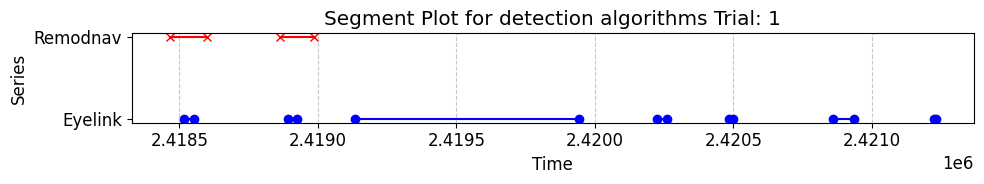

In [60]:
plot_comparison(df_eyelink, df_remodnav, 1)

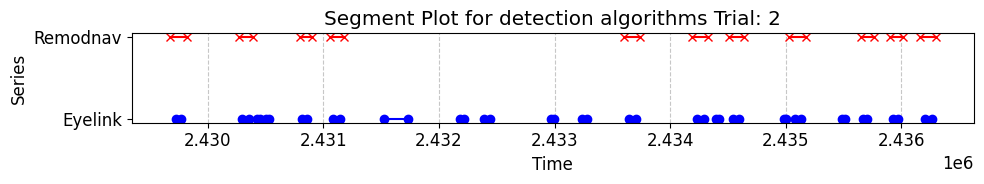

In [61]:
plot_comparison(df_eyelink, df_remodnav, 2)

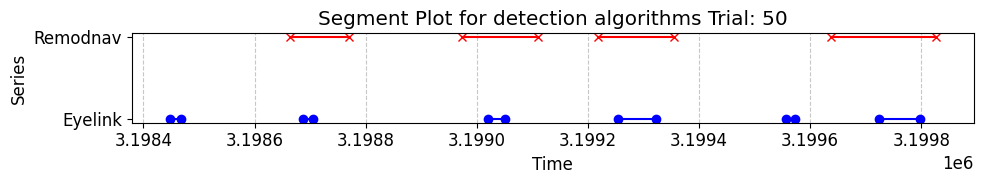

In [62]:
plot_comparison(df_eyelink, df_remodnav, 50)

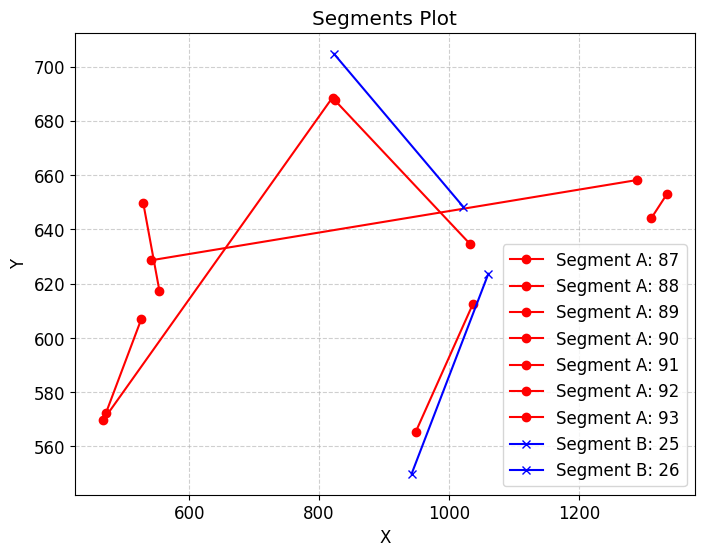

In [63]:
plot_screen(df_eyelink, df_remodnav, 1)

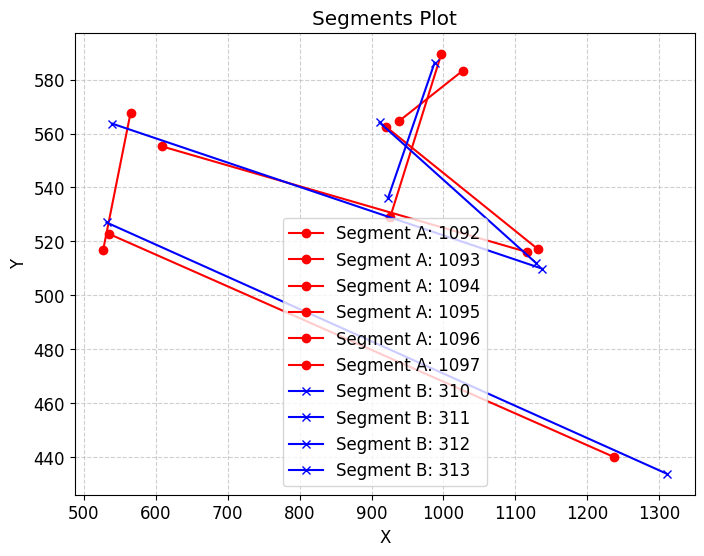

In [64]:
plot_screen(df_eyelink, df_remodnav, 50)

# Fixations

In [65]:
remodnav_fix_path = derivatives_path / "sub-0001" / "ses-second" / "remodnav_events" / "fix.feather"
eyelink_fix_path = derivatives_path / "sub-0001" / "ses-second" / "eyelink_events" / "fix.feather"

df_fix_remodnav = pd.read_feather(remodnav_fix_path)
df_fix_eyelink = pd.read_feather(eyelink_fix_path)

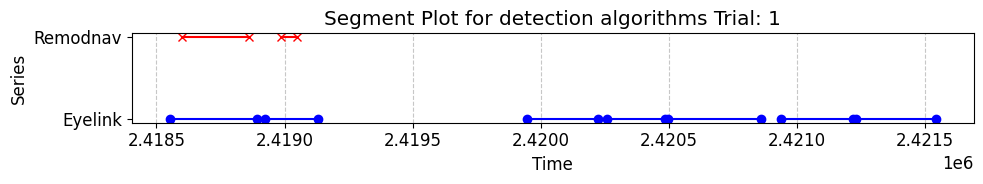

In [66]:
plot_comparison(df_fix_eyelink, df_fix_remodnav, 1)

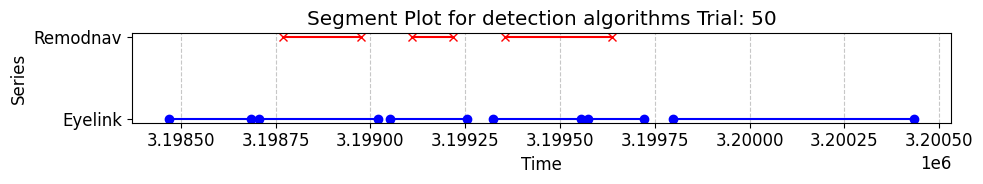

In [67]:
plot_comparison(df_fix_eyelink, df_fix_remodnav, 50)